## Caveat
Just the usual, install PennyLane and the qiskit stuff to use the qasm converter, so on. I assume you can do that.

In [ ]:
!wget https://qulacs-quantum-datasets.s3.us-west-1.amazonaws.com/base_test_mnist_784_f90.zip
!unzip base_test_mnist_784_f90.zip

## Conversion in numpy arrays for the target states
This procedure is totally optional, just if you want the states also in numpy array, I use this only later to check if the state of the circuits if close (fidelity affects the result) to the target states.

In [1]:
import numpy as np
import os

directory = "base_test_mnist_784_f90/state/"
output_directory = "base_test_mnist_784_f90/numpy_arrays/"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    
    if os.path.isfile(file_path):
        # Assuming the filename is an integer
        try:
            file_index = int(filename)
        except ValueError:
            continue
        
        # Read the complex vectors from the file
        with open(file_path, 'r') as f:
            lines = f.readlines()

        complex_vectors = []
        for line in lines:
            parts = line.strip().split()
            real_part = float(parts[0])
            imaginary_part = float(parts[1])
            complex_vectors.append(complex(real_part, imaginary_part))
        
        # Convert the complex vectors to numpy arrays
        state_array = np.array(complex_vectors)
        
        # Save the numpy array in the specified output directory
        output_filename = f"{file_index}.npy"
        output_path = os.path.join(output_directory, output_filename)
        
        np.save(output_path, state_array)

print("Conversion complete.")

Conversion complete.


## Check that the circuits output the desired states

In [1]:
import os
import pennylane as qml
import numpy as np

path_qasm = "base_test_mnist_784_f90/qasm/"
path_label = "base_test_mnist_784_f90/label/"

lim = len(os.listdir(path_label))

circuits = []
labels = []

for i in range(lim):
    with open(os.path.join(path_qasm, str(i))) as f:
        qasm = f.read()

    with open(os.path.join(path_label, str(i))) as g:
        label = g.read()

    my_circuit = qml.from_qasm(qasm)
    
    # Append the circuit and label to the respective lists
    circuits.append(my_circuit)
    labels.append(label)

# Convert the lists to numpy arrays
circuits_array = np.array(circuits)
labels_array = np.array(labels)

print("Number of circuits:", len(circuits_array))
print("Number of labels:", len(labels_array))


Number of circuits: 10000
Number of labels: 10000


In [64]:
dev = qml.device("default.qubit", wires=10, shots = None)    

index_checked = 0


def create_circuit_qnode(element, dev  = dev):
    @qml.qnode(dev)
    def circuit():
        element(wires=[9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
        return qml.state()
    
    return circuit

#draw the circuit
drawer = qml.draw(create_circuit_qnode(circuits_array[index_checked]))
print(drawer())

#this is just a way to load any circuit we want
circuit_qnode = create_circuit_qnode(circuits_array[index_checked])
state = circuit_qnode()
print("circuit state", state)


### Now just for fun you can check if it relatively matches the actual target state (which would be 100% fidelity tho)
arrays_directory = "base_test_mnist_784_f90/numpy_arrays/"
L = np.load(arrays_directory + f"{index_checked}.npy")
print("array", L)


# Compare the final state with the loaded numpy array L
error_threshold = 0.1 #Fidelity affects this number
if np.allclose(state, L, atol= error_threshold):
   print("The final state matches the loaded numpy array.")
else:
    print("The final state does not match the loaded numpy array.")
# It cannot match because is the target state, but you can create a threshold.

0: ──U3(2.41,1.51,1.52)──────────────────────────────────────────────────────────────────────
1: ──X───────────────────────────────────────────────────────────────────────────────────────
2: ──────────────────────────────────────────────────────────────────────────────────────────
3: ──X───────────────────────────────────────────────────────────────────────────────────────
4: ──X───────────────────U3(0.72,-1.57,-3.14)─╭X──U3(1.09,-0.57,2.42)─╭X──U3(0.83,0.00,1.57)─
5: ───────────────────────────────────────────│───────────────────────│──────────────────────
6: ───────────────────────────────────────────│───────────────────────│──────────────────────
7: ───────────────────────────────────────────│───────────────────────│──────────────────────
8: ──X────────────────────────────────────────│───────────────────────│───U3(1.51,-1.57,0.00)
9: ──X───────────────────U3(1.57,-1.56,-1.57)─╰●──U3(1.63,-3.14,1.57)─╰●──U3(1.57,1.57,3.13)─

──╭X────────────────────U3(1.56,-1.41,1.71)─╭X──U3(2.30,-1.

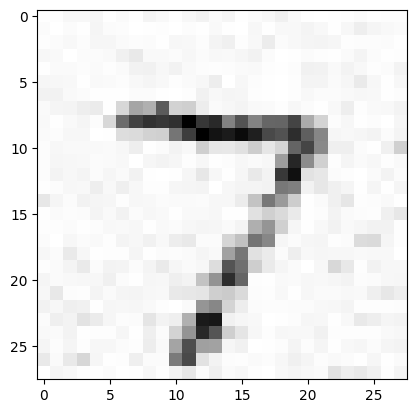

7


In [66]:
#state picture 
import matplotlib.pyplot as plt

def show_figure(pict: np.array):
    plt.imshow(pict.reshape(28, 28), cmap="Greys")
    plt.show()

def show_state_figure(state):
    pict = state
    result = []
    for x in range(28 * 28):
        result.append(abs(pict[x]))
    show_figure(np.array(result))

show_state_figure(state)
print(labels_array[0])